<a href="https://colab.research.google.com/github/asetya/BigData/blob/master/keyframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install peakutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def scale(img, xScale, yScale):
    res = cv2.resize(img, None, fx=xScale, fy=yScale, interpolation=cv2.INTER_AREA)
    return res


def crop(infile, height, width):
    im = Image.open(infile)
    imgwidth, imgheight = im.size
    for i in range(imgheight // height):
        for j in range(imgwidth // width):
            box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
            yield im.crop(box)


def averagePixels(path):
    r, g, b = 0, 0, 0
    count = 0
    pic = Image.open(path)
    for x in range(pic.size[0]):
        for y in range(pic.size[1]):
            imgData = pic.load()
            tempr, tempg, tempb = imgData[x, y]
            r += tempr
            g += tempg
            b += tempb
            count += 1
    return (r / count), (g / count), (b / count), count

def convert_frame_to_grayscale(frame):
    grayframe = None
    gray = None
    if frame is not None:
        cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = scale(gray, 1, 1)
        grayframe = scale(gray, 1, 1)
        gray = cv2.GaussianBlur(gray, (9, 9), 0.0)
    return grayframe, gray

def prepare_dirs(keyframePath, imageGridsPath, csvPath):
    if not os.path.exists(keyframePath):
        os.makedirs(keyframePath)
    if not os.path.exists(imageGridsPath):
        os.makedirs(imageGridsPath)
    if not os.path.exists(csvPath):
        os.makedirs(csvPath)


def plot_metrics(indices, lstfrm, lstdiffMag):
    y = np.array(lstdiffMag)
    plt.plot(indices, y[indices], "x")
    l = plt.plot(lstfrm, lstdiffMag, 'r-')
    plt.xlabel('frames')
    plt.ylabel('pixel difference')
    plt.title("Pixel value differences from frame to frame and the peak values")
    plt.show()

In [7]:
import os
import cv2
import csv
import numpy as np
import time
import peakutils
#from KeyFrameDetector.utils import convert_frame_to_grayscale, prepare_dirs, plot_metrics

In [43]:
def keyframeDetection(source, dest, Thres, plotMetrics=False, verbose=False):

    keyframePath = dest+'/keyFrames'
    imageGridsPath = dest+'/imageGrids'
    csvPath = dest+'/csvFile'
    path2file = csvPath + '/output.csv'
    prepare_dirs(keyframePath, imageGridsPath, csvPath)

    cap = cv2.VideoCapture(source)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(length)

    if (cap.isOpened()== False):
        print("Error opening video file")

    lstfrm = []
    lstdiffMag = []
    timeSpans = []
    images = []
    full_color = []
    lastFrame = None
    Start_time = time.process_time()

    # Read until video is completed
    for i in range(length):
        ret, frame = cap.read()
        grayframe, blur_gray = convert_frame_to_grayscale(frame)

        frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES) - 1
        lstfrm.append(frame_number)
        images.append(grayframe)
        full_color.append(frame)
        if frame_number == 0:
            lastFrame = blur_gray

        diff = cv2.subtract(blur_gray, lastFrame)
        diffMag = cv2.countNonZero(diff)
        lstdiffMag.append(diffMag)
        stop_time = time.process_time()
        time_Span = stop_time-Start_time
        timeSpans.append(time_Span)
        lastFrame = blur_gray

    cap.release()

    y = np.array(lstdiffMag)
    #print (y)
    base = peakutils.baseline(y, 2)
    #print(base)
    indices = peakutils.indexes(y-base, Thres, min_dist=1)
    #print(indices)

    ##plot to monitor the selected keyframe
    if (plotMetrics):
        plot_metrics(indices, lstfrm, lstdiffMag)

    cnt = 1
    print(indices)
    for x in indices:
        cv2.imwrite(os.path.join(keyframePath , 'keyframe'+ str(cnt) +'.jpg'), full_color[x])
        cnt +=1
        print(cnt)
        log_message = 'keyframe ' + str(cnt) + ' happened at ' + str(timeSpans[x]) + ' sec.'
        if(verbose):
            print(log_message)
        with open(path2file, 'w') as csvFile:
            writer = csv.writer(csvFile)
            writer.writerows(log_message)
            csvFile.close()

    cv2.destroyAllWindows()

In [ ]:
from google.colab import drive

In [22]:

drive.mount('/content/drive')
source = '/content/drive/MyDrive/MixedReality/Asset/acrobacia.mp4'
dest = '/content/drive/MyDrive/MixedReality/Asset'
Thres = 0.1


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


175


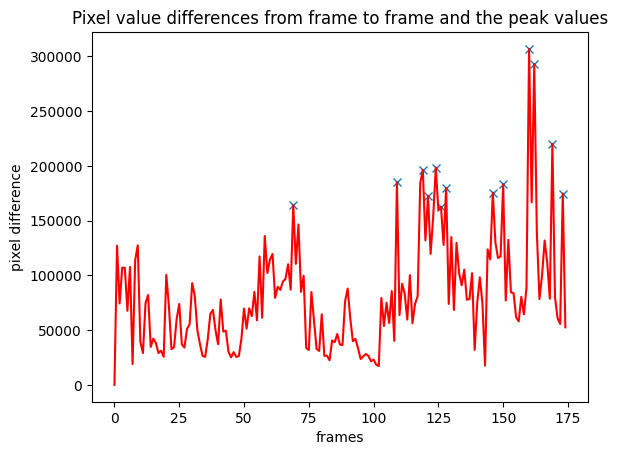

[ 69 109 119 121 124 126 128 146 150 160 162 169 173]
2
keyframe 2 happened at 0.7155670430000072 sec.
3
keyframe 3 happened at 1.1895177120000113 sec.
4
keyframe 4 happened at 1.3171155630000015 sec.
5
keyframe 5 happened at 1.3468567320000062 sec.
6
keyframe 6 happened at 1.3876706370000136 sec.
7
keyframe 7 happened at 1.4160348190000036 sec.
8
keyframe 8 happened at 1.4387499480000088 sec.
9
keyframe 9 happened at 1.6385956780000015 sec.
10
keyframe 10 happened at 1.6973368210000075 sec.
11
keyframe 11 happened at 1.821691400000006 sec.
12
keyframe 12 happened at 1.8411054960000115 sec.
13
keyframe 13 happened at 1.9328675550000014 sec.
14
keyframe 14 happened at 1.9853703530000075 sec.


In [45]:
keyframeDetection(source, dest, 0.5, plotMetrics=True, verbose=True)